In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
btc=pd.read_csv("BTC.csv",index_col="Date")

In [ ]:
btc

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Oct 11, 2021","57,477.3","54,686.9","57,814.1","54,457.8",73.84K,5.10%
"Oct 10, 2021","54,687.7","54,942.5","56,432.2","54,100.8",104.43K,-0.46%
"Oct 09, 2021","54,942.5","53,924.1","55,430.8","53,711.7",64.65K,1.91%
"Oct 08, 2021","53,914.7","53,785.5","55,977.9","53,659.3",64.05K,0.24%
"Oct 07, 2021","53,783.9","55,325.2","55,325.6","53,476.4",75.68K,-2.78%
...,...,...,...,...,...,...
"Jan 05, 2016",431.2,433.3,435.3,428.9,45.03K,-0.49%
"Jan 04, 2016",433.3,430.7,435.3,428.6,53.01K,0.61%
"Jan 03, 2016",430.7,433.7,434.1,423.1,54.83K,-0.70%


In [ ]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, Oct 11, 2021 to Jan 01, 2016
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     2111 non-null   object
 1   Open      2111 non-null   object
 2   High      2111 non-null   object
 3   Low       2111 non-null   object
 4   Vol.      2111 non-null   object
 5   Change %  2111 non-null   object
dtypes: object(6)
memory usage: 115.4+ KB


In [ ]:
btc['Price'] = btc['Price'].replace(',','', regex=True)

In [ ]:
btc.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Oct 11, 2021",57477.3,"54,686.9","57,814.1","54,457.8",73.84K,5.10%
"Oct 10, 2021",54687.7,"54,942.5","56,432.2","54,100.8",104.43K,-0.46%
"Oct 09, 2021",54942.5,"53,924.1","55,430.8","53,711.7",64.65K,1.91%
"Oct 08, 2021",53914.7,"53,785.5","55,977.9","53,659.3",64.05K,0.24%
"Oct 07, 2021",53783.9,"55,325.2","55,325.6","53,476.4",75.68K,-2.78%


In [ ]:
btc['Price'] = btc['Price'].astype(float, errors = 'raise')

In [ ]:
btc.index[::-1]

Index(['Jan 01, 2016', 'Jan 02, 2016', 'Jan 03, 2016', 'Jan 04, 2016',
       'Jan 05, 2016', 'Jan 06, 2016', 'Jan 07, 2016', 'Jan 08, 2016',
       'Jan 09, 2016', 'Jan 10, 2016',
       ...
       'Oct 02, 2021', 'Oct 03, 2021', 'Oct 04, 2021', 'Oct 05, 2021',
       'Oct 06, 2021', 'Oct 07, 2021', 'Oct 08, 2021', 'Oct 09, 2021',
       'Oct 10, 2021', 'Oct 11, 2021'],
      dtype='object', name='Date', length=2111)

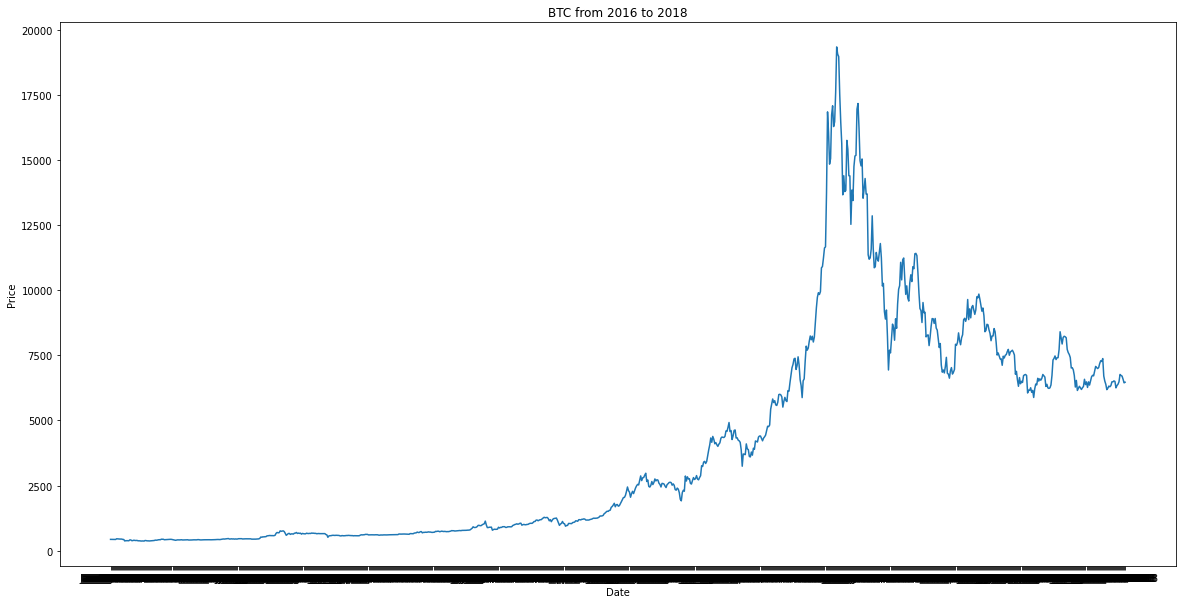

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(btc.index[::-1][:1000],btc['Price'][::-1][:1000])
pyplot.xlabel("Date")  
pyplot.ylabel("Price") 
pyplot.title("BTC from 2016 to 2018")  
pyplot.show()

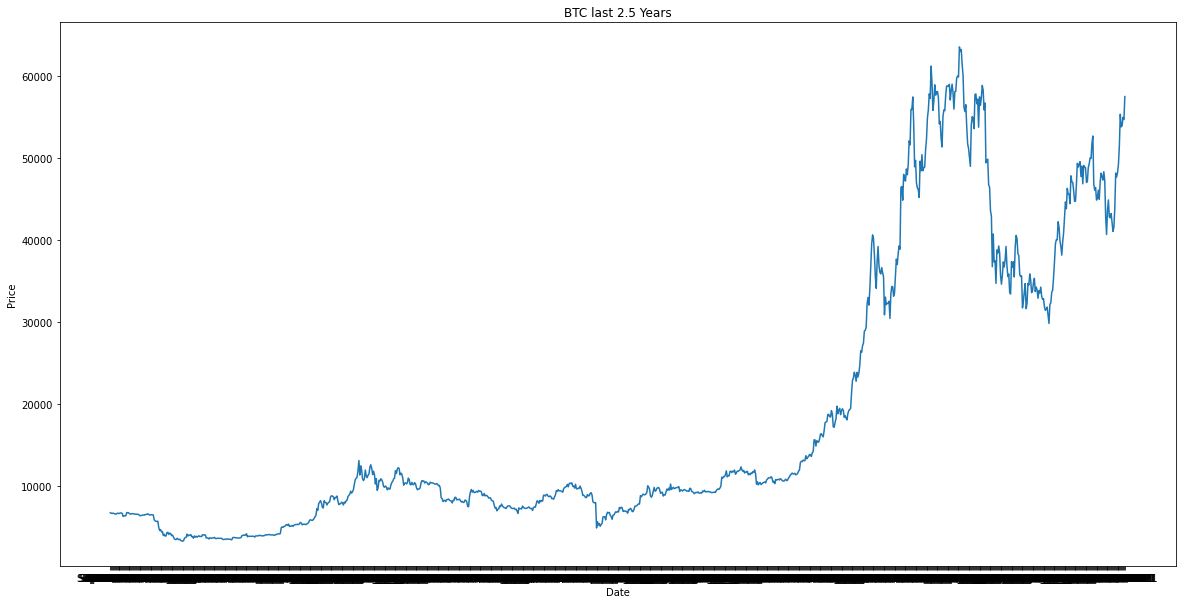

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(btc.index[::-1][1000:],btc['Price'][::-1][1000:])
pyplot.xlabel("Date")  
pyplot.ylabel("Price") 
pyplot.title("BTC last 2.5 Years")  
pyplot.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
values = btc['Price'][::-1].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
print(train)
print(scaled)

1477 634
[[0.00104475]
 [0.00104   ]
 [0.00099251]
 ...
 [0.1339372 ]
 [0.13376464]
 [0.13231783]]
[[0.00104475]
 [0.00104   ]
 [0.00099251]
 ...
 [0.86389107]
 [0.8598577 ]
 [0.9040159 ]]


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX,trainY)

1476
633
[[0.00104475]
 [0.00104   ]
 [0.00099251]
 ...
 [0.12257472]
 [0.1339372 ]
 [0.13376464]] [0.00104    0.00099251 0.00103367 ... 0.1339372  0.13376464 0.13231783]


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX[:5],testX[:5]

(array([[[0.00104475]],
 
        [[0.00104   ]],
 
        [[0.00099251]],
 
        [[0.00103367]],
 
        [[0.00100043]]], dtype=float32), array([[[0.13526528]],
 
        [[0.13531594]],
 
        [[0.13199015]],
 
        [[0.13097231]],
 
        [[0.13240804]]], dtype=float32))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

[[0.14134866]
 [0.14140046]
 [0.13800046]
 [0.13696001]
 [0.13842763]
 [0.13755223]
 [0.13312875]
 [0.13369174]
 [0.13210148]
 [0.13640825]
 [0.1405961 ]
 [0.14886263]
 [0.14759341]
 [0.15096736]
 [0.14840607]
 [0.14893222]
 [0.14817618]
 [0.14755614]
 [0.14589363]
 [0.15265942]
 [0.15525359]
 [0.15600826]
 [0.15725368]
 [0.16140014]
 [0.15658319]
 [0.16266367]
 [0.1640925 ]
 [0.16275437]
 [0.16434036]
 [0.15745126]
 [0.15784968]
 [0.15411031]
 [0.16151191]
 [0.15262057]
 [0.15250722]
 [0.15383664]
 [0.15337029]
 [0.15801813]
 [0.15348363]
 [0.14788966]
 [0.1395232 ]
 [0.13981931]
 [0.13785969]
 [0.1353711 ]
 [0.13531125]
 [0.14121436]
 [0.13889371]
 [0.13883705]
 [0.14373109]
 [0.144937  ]
 [0.14093922]
 [0.12712766]
 [0.12549265]
 [0.12481668]
 [0.1255266 ]
 [0.07531357]
 [0.08754753]
 [0.08106726]
 [0.08402956]
 [0.07860392]
 [0.08233216]
 [0.08395049]
 [0.09703502]
 [0.09757273]
 [0.09726433]
 [0.09138583]
 [0.10182989]
 [0.10628351]
 [0.1052221 ]
 [0.10596848]
 [0.10028744]
 [0.09

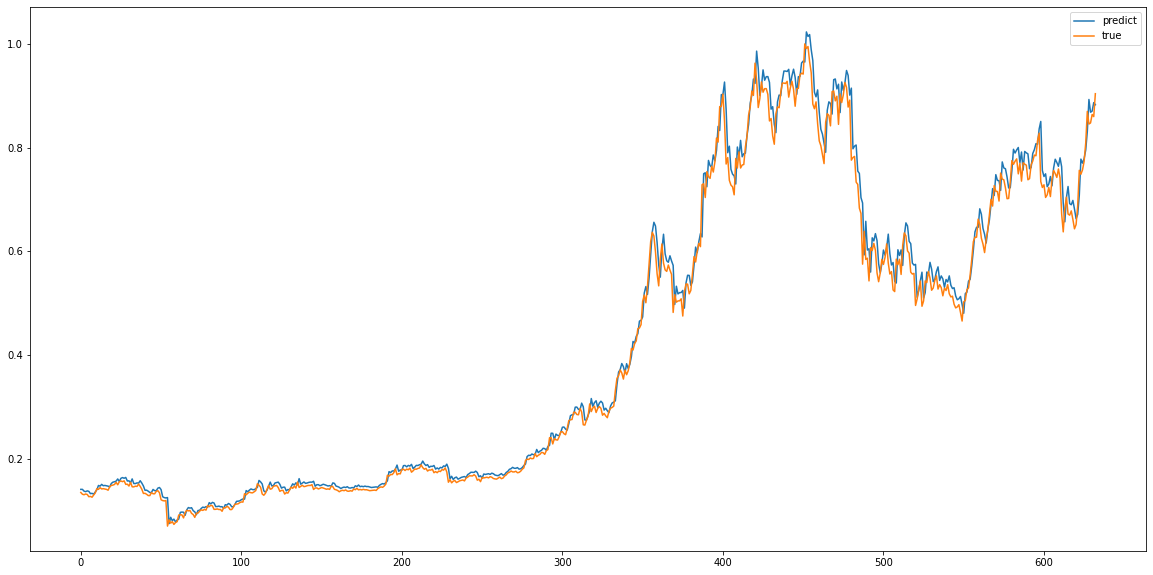

In [ ]:
yhat = model.predict(testX)
print(yhat)
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [ ]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1588.474


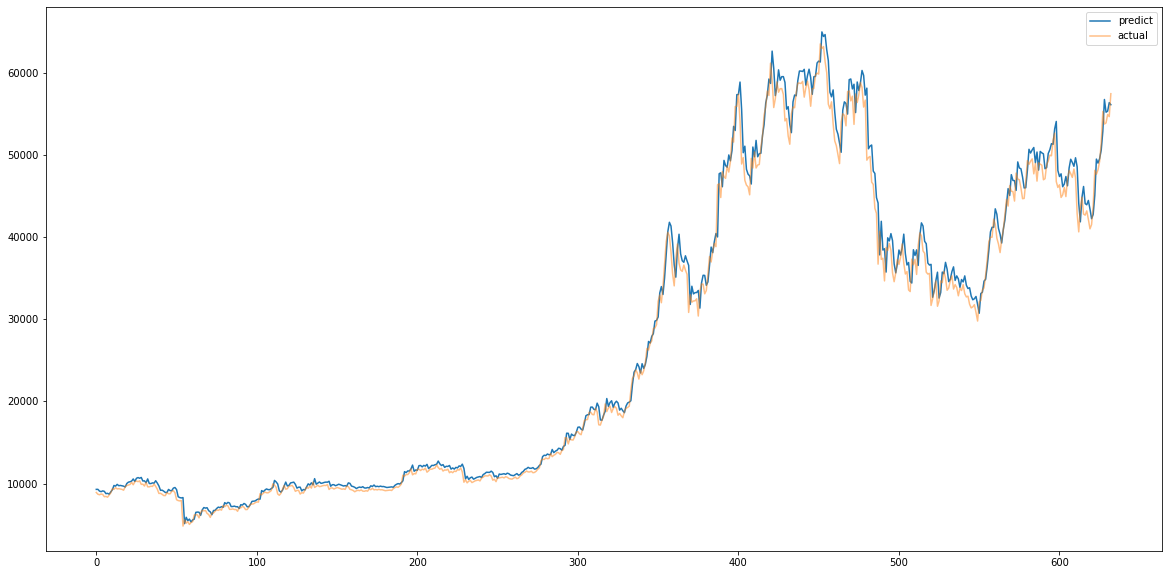

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [ ]:
predictDates = btc.tail(len(testX)).index

In [ ]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [ ]:
yhat_inverse

In [ ]:
model.save("model1.h5")

In [ ]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
model1 = load_model('model1.h5')
# summarize model.
model1.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.predict([[[0.9040159 ]]])

array([[0.92712826]], dtype=float32)

In [ ]:
print(scaled[::-1][:10])

[[0.9040159 ]
 [0.8598577 ]
 [0.86389107]
 [0.8476214 ]
 [0.8455509 ]
 [0.86991733]
 [0.8089118 ]
 [0.7734219 ]
 [0.75716174]
 [0.74872136]]


In [ ]:
yhat1=[]
prev=0.9040159
#50 means next 50 days from 11th OCT 2021
for i in range(0,50):
  x=model1.predict([[[prev]]])
  yhat1.append(x[0][0])
  prev=x[0][0].item()

In [ ]:
print(yhat1)

[0.92712826, 0.95031345, 0.9735225, 0.9967034, 1.0198041, 1.0427703, 1.0655477, 1.0880815, 1.1103185, 1.1322064, 1.1536947, 1.1747358, 1.195285, 1.215301, 1.2347476, 1.2535914, 1.2718047, 1.2893646, 1.3062522, 1.3224545, 1.3379631, 1.3527734, 1.3668853, 1.3803034, 1.393036, 1.4050939, 1.4164912, 1.4272451, 1.4373745, 1.4469005, 1.4558449, 1.4642308, 1.4720825, 1.4794245, 1.4862819, 1.4926789, 1.4986402, 1.5041898, 1.5093513, 1.5141476, 1.518601, 1.5227326, 1.5265635, 1.5301124, 1.5333985, 1.5364393, 1.5392524, 1.5418526, 1.5442553, 1.546475]


In [ ]:
yhat1=np.array(yhat1)

In [ ]:
yhat1_inverse = scaler.inverse_transform(yhat1.reshape(-1, 1))

In [ ]:
yhat1_inverse
#(11th OCT to apna date)

array([[58937.38 ],
       [60402.055],
       [61868.234],
       [63332.64 ],
       [64791.98 ],
       [66242.82 ],
       [67681.734],
       [69105.26 ],
       [70510.04 ],
       [71892.76 ],
       [73250.24 ],
       [74579.46 ],
       [75877.61 ],
       [77142.086],
       [78370.586],
       [79561.   ],
       [80711.586],
       [81820.9  ],
       [82887.734],
       [83911.28 ],
       [84891.01 ],
       [85826.62 ],
       [86718.1  ],
       [87565.766],
       [88370.12 ],
       [89131.85 ],
       [89851.85 ],
       [90531.21 ],
       [91171.11 ],
       [91772.89 ],
       [92337.94 ],
       [92867.695],
       [93363.72 ],
       [93827.53 ],
       [94260.734],
       [94664.85 ],
       [95041.44 ],
       [95392.03 ],
       [95718.09 ],
       [96021.09 ],
       [96302.42 ],
       [96563.43 ],
       [96805.44 ],
       [97029.63 ],
       [97237.23 ],
       [97429.32 ],
       [97607.03 ],
       [97771.3  ],
       [97923.08 ],
       [98063.305]],